<a href="https://colab.research.google.com/github/ZeusKwon/DeepLearning_Project/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 : 이미지를 100%의 정확도로 구분하는 모델 만들기
<img src="https://user-images.githubusercontent.com/70212461/131807771-225ab885-c11f-4d2b-bf4a-14cbdd8acd63.jpg" width="80%" height="80%">  
## 주제 선정이유
- 저는 프로젝트를 진행하기에는 아직 딥러닝에 대한 학습이 부족할 뿐더러 도메인을 정하지 못한 부분이 있습니다. 그래서 남이 만들어놓은 코드를 그대로 가져오기보다는 기본에 충실해서 처음부터 코드를 하나씩 뜯어보는 프로젝트가 추후 저의 딥러닝공부에 대한 발전에 더 도움이 되겠다는 생각이 들었습니다. 그래서 성능 100%의 이미지 분류 모델을 만들어 보겠다는 주제로 프로젝트를 진행했습니다.

## 데이터
- 총 이미지 : 13798개
- 라벨 : 8개 
    - person(1972개) 
    - airplane(1454개) 
    - car(1936개) 
    - dog(1404개) 
    - cat(1770개) 
    - flower(1686개) 
    - fruit(2000개) 
    - motorbike(1576개)

# 목표
- 분류 모델 성능 : 100 % 달성

# 작업 순서
- 데이터 불러오기
- 이미지 전처리
- 베이스라인 모델 설정
- 모델 튜닝 후 성능 높이기
    - 데이터 증강
    - 전이 학습
- 모델 성능 확인
- 결론








## 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 이미지 경로를 데이터 프레임 형태로 만드는 함수

In [3]:
dir_ = Path('/content/drive/MyDrive/Colab Notebooks/Data_analysis_Project/03_딥러닝_이미지분류/imagedata')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)

In [ ]:
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Colab Notebooks/Data_an...,person
1,/content/drive/MyDrive/Colab Notebooks/Data_an...,airplane
2,/content/drive/MyDrive/Colab Notebooks/Data_an...,person
3,/content/drive/MyDrive/Colab Notebooks/Data_an...,airplane
4,/content/drive/MyDrive/Colab Notebooks/Data_an...,car


In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 13798

Number of different labels: 8

Labels: ['person' 'airplane' 'car' 'dog' 'cat' 'flower' 'fruit' 'motorbike']


- 이미지 데이터 확인 

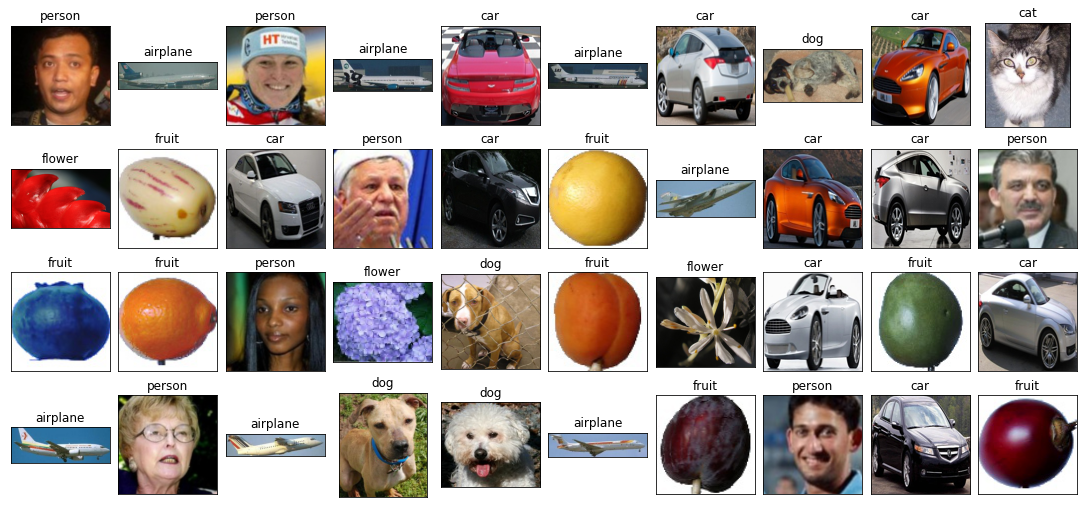

In [ ]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

### Label Category 분포 확인

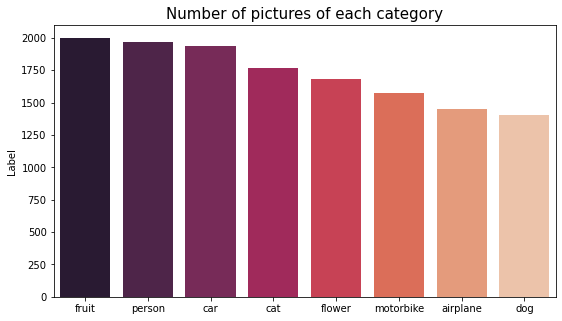

In [ ]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

### 이미지 데이터 Train, Test 데이터로 분류

In [5]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)

In [ ]:
train_df.shape,test_df.shape

((12418, 2), (1380, 2))

## 베이스 라인 모델 

### 모델 전처리

In [ ]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Data_analysis_Project/03_딥러닝_이미지분류/imagedata/data/natural_images',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Data_analysis_Project/03_딥러닝_이미지분류/imagedata/data/natural_images',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 5522 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.


### 딥러닝 CNN모델로 모델링

In [ ]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=8, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5308544   
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1

### 모델 성능 확인(accuracy) 

In [ ]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
173/173 [==============================] - 71s 408ms/step - loss: 0.3905 - accuracy: 0.8571 - val_loss: 0.3849 - val_accuracy: 0.8620
Epoch 2/10
173/173 [==============================] - 72s 416ms/step - loss: 0.3130 - accuracy: 0.8848 - val_loss: 0.4181 - val_accuracy: 0.8526
Epoch 3/10
173/173 [==============================] - 72s 416ms/step - loss: 0.2762 - accuracy: 0.9018 - val_loss: 0.3455 - val_accuracy: 0.8787
Epoch 4/10
173/173 [==============================] - 72s 419ms/step - loss: 0.2331 - accuracy: 0.9142 - val_loss: 0.3913 - val_accuracy: 0.8686
Epoch 5/10
173/173 [==============================] - 72s 417ms/step - loss: 0.2100 - accuracy: 0.9218 - val_loss: 0.2798 - val_accuracy: 0.9027
Epoch 6/10
173/173 [==============================] - 73s 422ms/step - loss: 0.1925 - accuracy: 0.9263 - val_loss: 0.2551 - val_accuracy: 0.9136
Epoch 7/10
173/173 [==============================] - 73s 419ms/step - loss: 0.1765 - accuracy: 0.9317 - val_loss: 0.2838 - val_ac

- 베이스 라인 모델 성능 결과 
 - accuracy : 0.9488
 - val_accuracy : 0.8932

## 모델 성능 높이기

### 데이터 증강(Data Augmentation)으로 이미지 로드

In [6]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

### 전이학습을 사용해서 모델 성능 높이기

In [ ]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    # "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    # "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(8, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 2236 validated image filenames belonging to 8 classes.
Found 248 validated image filenames belonging to 8 classes.
Found 276 validated image filenames belonging to 8 classes.


29097984/29084464 [==============================] - 0s 0us/step
DenseNet121          trained in 583.02 sec
9420800/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 16.65 sec
74850304/74836368 [==============================] - 1s 0us/step
DenseNet201          trained in 44.48 sec
87924736/87910968 [==============================] - 1s 0us/step
InceptionV3          trained in 23.67 sec
17620992/17605208 [==============================] - 0s 0us/step
MobileNetV3Large     trained in 18.62 sec
234561536/234545216 [==============================] - 3s 0us/step
ResNet152V2          trained in 54.09 sec
94683136/94668760 [==============================] - 1s 0us/step
ResNet50V2           trained in 19.11 sec
80150528/80134624 [==============================] - 1s 0us/step
VG

In [ ]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

**DenseNet121 has a 99.64% accuracy on the test set**
**MobileNetV2 has a 99.64% accuracy on the test set**
**DenseNet201 has a 100.00% accuracy on the test set**
**InceptionV3 has a 99.64% accuracy on the test set**
**MobileNetV3Large has a 53.26% accuracy on the test set**
**ResNet152V2 has a 100.00% accuracy on the test set**
**ResNet50V2 has a 100.00% accuracy on the test set**
**VGG16 has a 96.74% accuracy on the test set**
**Xception has a 99.64% accuracy on the test set**


In [ ]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet201,1.0000,1.0000,49.20
1,ResNet152V2,0.9919,1.0000,58.44
2,ResNet50V2,0.9919,1.0000,21.12
3,DenseNet121,1.0000,0.9964,1197.90
4,MobileNetV2,0.9960,0.9964,16.69
5,InceptionV3,0.9798,0.9964,25.27
6,Xception,1.0000,0.9964,32.77
7,VGG16,0.9677,0.9674,46.58
8,MobileNetV3Large,0.5806,0.5326,18.55


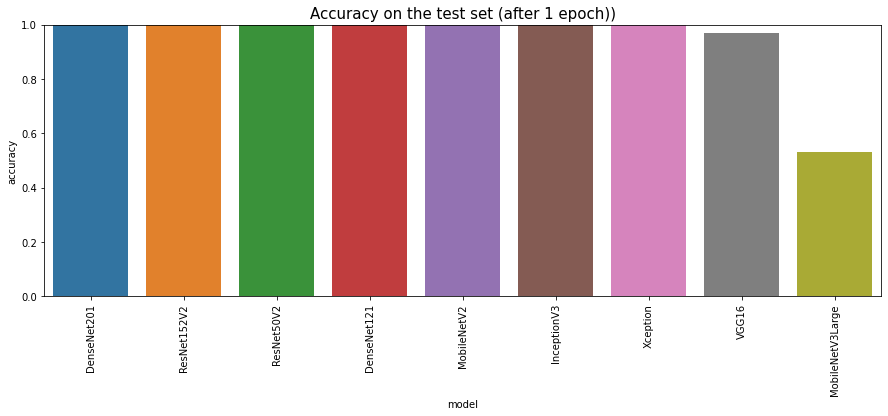

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

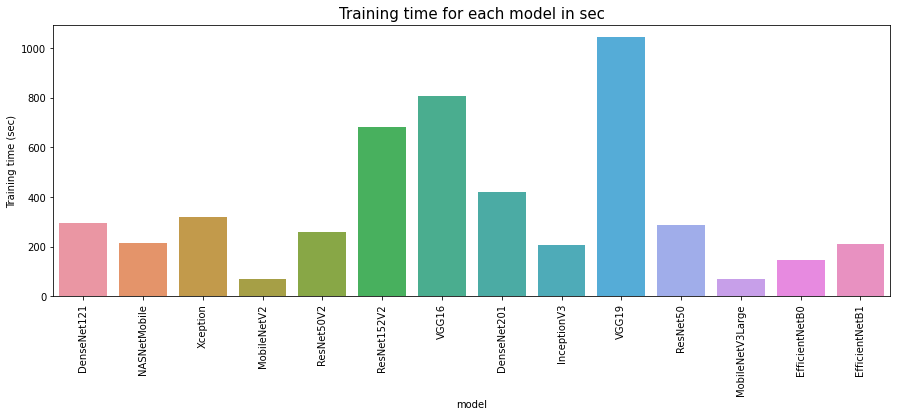

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

## 모델 성능 확인 _ DenseNet201, ResNet152v2(test 데이터)

### 좋은 효율을 내는 모델 성능확인 1 (DenseNet201)

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 5589 validated image filenames belonging to 8 classes.
Found 620 validated image filenames belonging to 8 classes.
Found 690 validated image filenames belonging to 8 classes.
Epoch 1/7
175/175 [==============================] - 24s 117ms/step - loss: 0.1121 - accuracy: 0.9707 - val_loss: 0.0133 - val_accuracy: 0.9952
Epoch 2/7
175/175 [==============================] - 20s 111ms/step - loss: 0.0084 - accuracy: 0.9982 - val_loss: 0.0145 - val_accuracy: 0.9952
Epoch 3/7
175/175 [==============================] - 19s 110ms/step - loss: 0.0130 - accuracy: 0.9961 - val_loss: 0.0137 - val_accuracy: 0.9935
Epoch 4/7
175/175 [==============================] - 19s 111ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0168 - val_accuracy: 0.9952
Epoch 5/7
175/175 [==============================] - 19s 111ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0296 - val_accuracy: 0.9952
Epoch 6/7
175/175 [==============================] - 19s 111ms/step - loss: 2.4648e-04 - accuracy: 

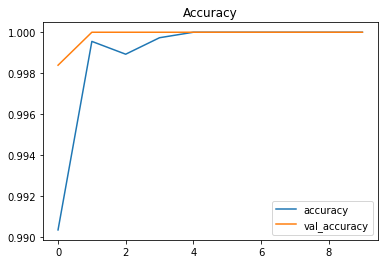

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

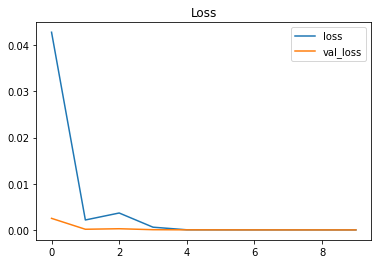

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 99.71%


### 좋은 효율을 내는 모델 성능확인 2 (ResNet152V2)

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet152V2)
history = model.fit(train_images,validation_data=val_images,epochs=5)

Found 5589 validated image filenames belonging to 8 classes.
Found 620 validated image filenames belonging to 8 classes.
Found 690 validated image filenames belonging to 8 classes.
Epoch 1/5
175/175 [==============================] - 57s 291ms/step - loss: 0.0610 - accuracy: 0.9841 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 2/5
175/175 [==============================] - 47s 269ms/step - loss: 0.0055 - accuracy: 0.9975 - val_loss: 0.0064 - val_accuracy: 0.9984
Epoch 3/5
175/175 [==============================] - 47s 269ms/step - loss: 6.3122e-04 - accuracy: 1.0000 - val_loss: 7.2853e-04 - val_accuracy: 1.0000
Epoch 4/5
175/175 [==============================] - 48s 276ms/step - loss: 8.7960e-05 - accuracy: 1.0000 - val_loss: 8.8865e-05 - val_accuracy: 1.0000
Epoch 5/5
175/175 [==============================] - 48s 273ms/step - loss: 2.1572e-05 - accuracy: 1.0000 - val_loss: 7.1390e-05 - val_accuracy: 1.0000


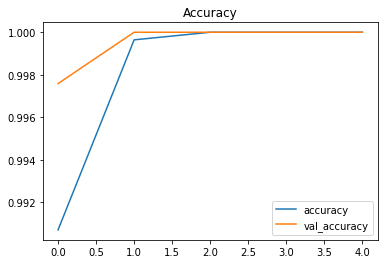

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

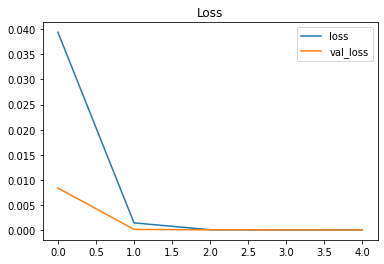

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')

# Accuracy on the test set: 100.00%

### 성능 100% 모델 정밀도와 재현율 

In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00       167
         car       1.00      1.00      1.00       191
         cat       1.00      1.00      1.00       146
         dog       1.00      1.00      1.00       162
      flower       1.00      1.00      1.00       157
       fruit       1.00      1.00      1.00       210
   motorbike       1.00      1.00      1.00       159
      person       1.00      1.00      1.00       188

    accuracy                           1.00      1380
   macro avg       1.00      1.00      1.00      1380
weighted avg       1.00      1.00      1.00      1380



### Confusion Matrix 시각화

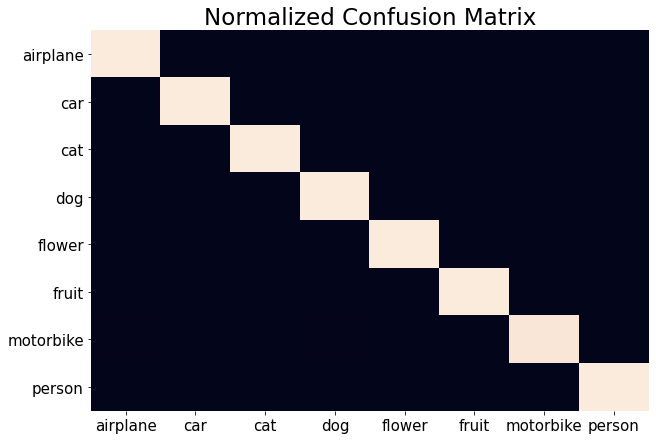

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### 실전 : 모델 예측 

번호를 입력하세요 : 40


## 예측률 : 100.00%

### Class prediction = person

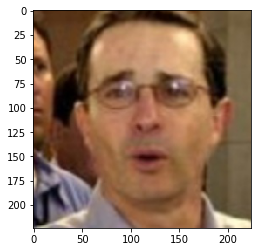

In [27]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
class_dictionary = {'airplane': 0,
                    'car': 1,
                    'cat': 2,
                    'dog': 3,
                    'flower': 4,
                    'fruit': 5,
                    'motorbike': 6,
                    'person': 7}
IMAGE_SIZE    = (224, 224)
number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

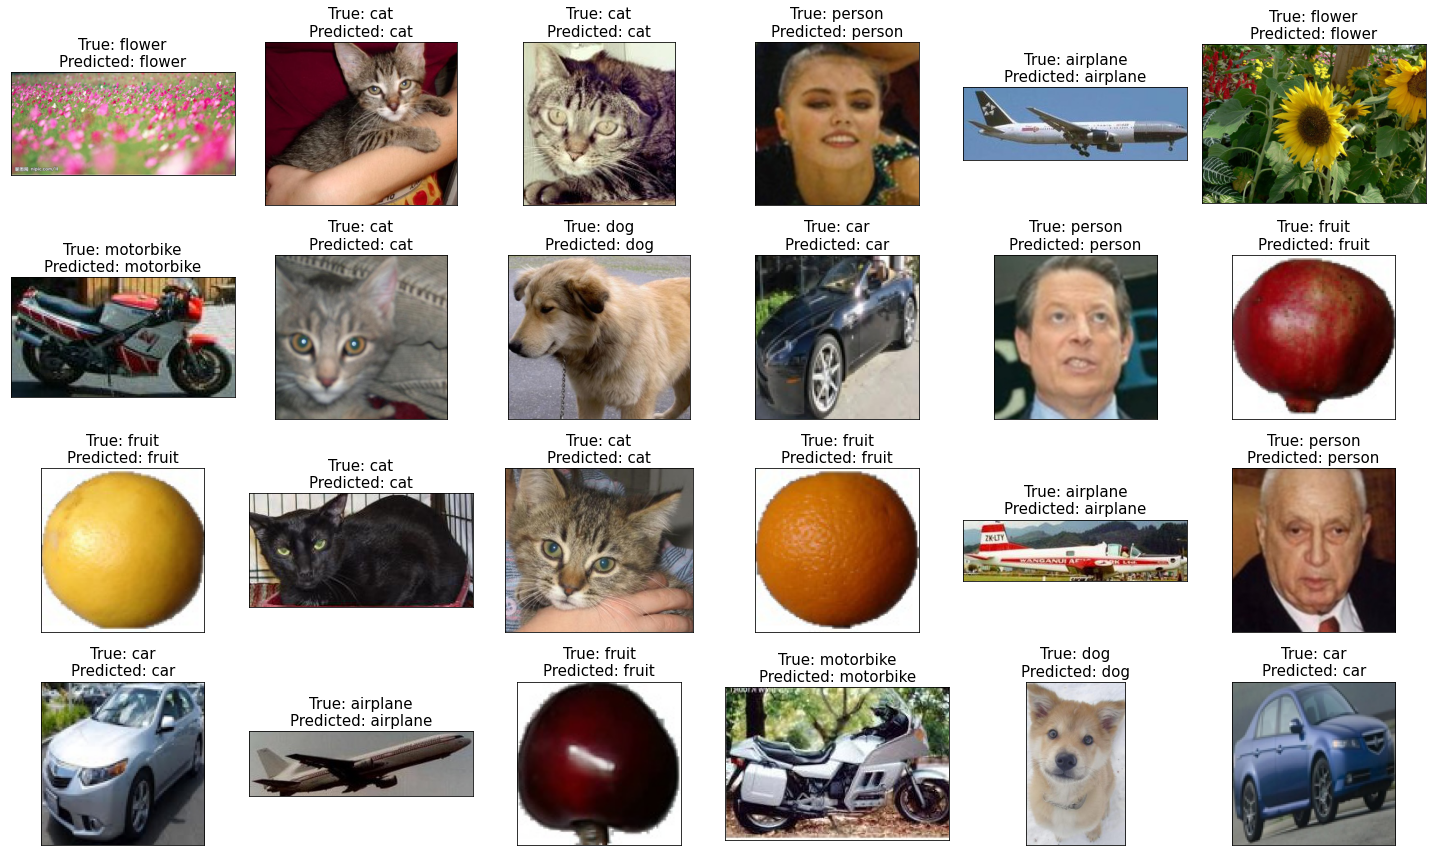

In [ ]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

## 결론 & 마무리


### 프로젝트 목표 : 이미지 분류 모델 성능 100% 만들기 성공

8개의 범주로 분류되어있는 10000개가 넘는 이미지 데이터를 100%에 근접하는 확률로 예측하는 모델을 만드는데 성공 할 수 있었습니다.

- 발전가능성  
전이학습을 활용해서 높은 성능의 모델을 만드는 법을 이번 프로젝트를 통해서 배울 수 있었습니다. 그리고 현재는 단순분류 모델이지만 좋은 성능의 모델을 만들어본 경험을 통해 향후 이미지/영상에서의 어떤 딥러닝 프로젝트를 진행할 때에도 모델성능을 높이는데 크게 도움이 될것으로 봅니다.



###  향후 프로젝트  
이번 프로젝트의 높은 성능을 나타내는 모델을 이용해서 향후 프로젝트 계획  
    - **프로젝트 1**   
    마스크 판별 딥러닝 프로젝트  
    마스크를 쓰고 있는지 안쓰고 있는지를 구분하는 프로젝트  
    ![마스크](https://user-images.githubusercontent.com/70212461/131808343-8771e6c2-3bdc-405b-b88b-cca3bc8ab3f7.png)  
    - **프로젝트 2**  
    사진 분석 후 비슷한 사진 추천 & 설명  
    사진이 주어졌을 때 비슷한 사진을 찾아주는 프로젝트
    ![향후 프로젝트2](https://user-images.githubusercontent.com/70212461/131808810-e8302ef9-acc0-43c7-a02e-b536e1d69e00.PNG)  
    - **프로젝트 3**  
    사진내 물체 분석  
    사진이 주어졌을 때 사진내에 어떤 물제가 있고 어떤 사람이 있는지 구분해주는 프로젝트  
    ![사진내 물체 분석](https://user-images.githubusercontent.com/70212461/131809465-4d5d3224-5e5a-4200-b24d-314d9e2ebd5a.jpg)


